<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <title>Exoplanet Transit Guide</title>
    <style>
        h1, h2 {
            color: skyblue;
        }
    </style>
</head>
<body>

<h1>Exoplanet Transit Guide</h1>

<h2>Section 0: Overview</h2>
<p>
I have broken down the process of capturing and processing an exoplanet transit into eight steps which are outlined below. This quick overview will help the reader understand the whole process before diving into the specific details of each step. If you are just working with the provided transit images then you can skip steps 1 and 2.
</p>
<ul>
    <li><a href="#selecting-a-transit">Section 1: Selecting a Transit</a> - This section describes 6 things to keep in mind when selecting a transit. It also provides some good resources for finding a suitable transit.</li>
    <li><a href="#Loading-Images">Section 2: Loading Images</a></li>
    <li><a href="#Flat/Bias Correction">Section 3: Flat/Bias Correction</a></li>
    <li><a href="#Aperture-Test">Section 4: Aperture Test</a></li>
    <li><a href="#Star-Tracking">Section 5: Star Tracking</a></li>
    <li><a href="#Differential-Photometry">Section 6: Differential Photometry</a></li>
    <li><a href="#Plotting-Transit">Section 7: Plotting Transit</a></li>
    <li><a href="#Estimating-Exoplanet-Information">Section 8: Estimating Exoplanet Information</a></li>
</ul>


<h2 style="color: skyblue;" id="selecting-a-transit">Section 1: Selecting a Transit</h2>
<p>
When selecting the exoplanet transit the weather is of course important above all else. Clouds can cause a drop in brightness over 40% in my experience and when looking for a drop around 1% this can make it impossible to measure even with differential photometry. If you're using the York University observatory they provide a great resource for helping you choose a clear night for your transit but the data is only for the next 72 hours: <a href="https://www.cleardarksky.com/c/YrkUObONkey.html?1">York University Observatory Clear Sky Chart</a>. Once you have a clear night selected there are 5 main things to think about for selecting the specific transit:
</p>
<ol>
    <li><strong>Stellar Magnitude</strong> - The brightness measurement. With the light collecting power of the 1 meter telescope the upper limit is around 15. Any less bright and the exposure times would likely be too long. If you find a transit around 14-15 Vmag you can look at the starfield by generating a starfield with the <a href="http://var2.astro.cz/ETD/predictions.php">Exoplanet Transit Database</a> to ensure there are no other really bright stars in the FOV. If this is the case you may be able to capture the transit with long exposure times.</li>
    <li><strong>Transit Depth</strong> - Generally we want a drop in brightness around 1% or more in order to accurately extract the transit but a larger transit depth is always easier to detect.</li>
    <li><strong>Transit Duration</strong> - The length of the transit is important because of telescope availability as well as finding a window of good weather. The shorter the transit the higher the chances of success.</li>
    <li><strong>Transit Start Time</strong> - You need the transit to occur at night and ideally you want it to start at least 1 hour and 15 minutes after sunset (45 mins for twilight and 30 mins for a baseline before the transit). The <a href="https://www.cleardarksky.com/c/YrkUObONkey.html?1">York University Observatory Clear Sky Chart</a> has estimates for the brightness.</li>
    <li><strong>Celestial Position</strong> - The following link can be used to ensure that your object is at least 20 degrees above the horizon from 30 minutes before to 30 minutes after the transit: <a href="http://catserver.ing.iac.es/staralt/index.php">STARALT</a></li>
</ol>
<p>
The <a href="http://var2.astro.cz/ETD/predictions.php">Exoplanet Transit Database</a> is a great resource. With a given Lat and Long and date it will give you a list of confirmed transits that are visible from your location and more than 20 degrees above the horizon mid transit. It can also be used to make a finder chart so that you can identify which star is the transit star. It also includes all of the important information mentioned above. You can then input the given RA and Dec into <a href="http://catserver.ing.iac.es/staralt/index.php">STARALT</a></li> to confirm it is viewable for the entire transit.
</p>


<h2 style="color: skyblue;" id="Loading-Images">Section 2: Loading Images</h2>
<p>

 After you download the images, you will be given the following: 
 <li> 20 bias frames, ex. "Bias_2x2-0001" </li>
 <li>20 flat frames, ex. "Flat_R_2x2_0001" </li>
 You will also be given the transit images, ex. "KOI-13_LIGHT_R_3s_BIN2_-10C_001_20240519_222732_343_PA36.04" 

Ensure that both your transit images and your Flat images you download contain the same filter, which should be red. This is indicated by the _ R _ in the names. The name of the transit images include the date and time the image was taken.
</p>

In [ ]:
import os
from astropy.io import fits
import matplotlib.pyplot as plt

def load_fits_images(folder_path, keyword):
    """
    Loads all fits images from a given folder that have the given keyword and stores the time the image was taken as well.
    ex: Flat_R to load flats images with the red filter
    """
    images = []
    
    for filename in os.listdir(folder_path):
        if keyword in filename:
            file_path = os.path.join(folder_path, filename)
            with fits.open(file_path) as hdul:
                image_data = hdul[0].data
                images.append({'data': image_data, 'filename': filename, 'header': hdul[0].header})

    if not images:
        raise FileNotFoundError(f"No FITS files with keyword '{keyword}' found in the folder '{folder_path}'")

    return images

# Example usage
folder = "D:\\TransitResearch\\2024-05-19+20\\2024-05-19+20"
keyword = "Flat_R"
images = load_fits_images(folder, keyword)

# show the first image
plt.figure()
plt.imshow(images[0]['data'], cmap='gray')
plt.title('First Image')
plt.colorbar()
plt.show()

# clear memory of unneeded images
del images


<h2 style="color: skyblue;" id="Flat/Bias Correction">Section 3: Flat/Bias Correction</h2>
<p>

## Bias Frames
These are images taken with the smallest exposure time possible (0.1s at the Yorku observatory) and the shutter closed so there is no light. They are used to correct for electric noise introduced during the readout proccess.

## Flat Frames ## 
These are images taken of a uniformly lit surface. At the Yorku observatory they are taken with a lamp pointed at the telescope dome. They are used to correct for the slightly different sensitivity of each pixel in the CCD camera. They also correct for any artifacts or dust in the optical path.

## Calibrating frames
<ol>
<li> Load the flat and bias frames. Create a single flat and single bias image by taking the average of the 20 images you are provided.</li>
<li> Subtract the bias from all frames including the flat frame. </li>
<li> divide the transit images by the flat frame to get your corrected frames. </li>
</ol>
</p>


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits

def calibrate_and_save_images(science_images, flat_images, bias_images, output_folder):
    """
    Calibrate science images using the provided flat and bias frames,
    and save the calibrated images to the specified folder.
    """
    # Median combine the flat and bias frames
    flat_stack = np.array([img['data'] for img in flat_images])
    Flat = np.median(flat_stack, axis=0)
    bias_stack = np.array([img['data'] for img in bias_images])
    Bias = np.median(bias_stack, axis=0)
    # correct the flat frame with the bias frame
    Flat = Flat - Bias
    Flat = Flat / np.median(Flat)  # Normalize the flat field
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Calibrate and save each science image one at a time
    for science_image in science_images:
        # Subtract bias and divide by the normalized flat
        calibrated_image = (science_image['data'] - Bias) / Flat
        # Get the original filename, if available
        original_filename = science_image.get('filename', f"Calibrated_.fits")
        # Sanitize the filename by replacing colons with underscores
        sanitized_filename = original_filename.replace(":", "_")
        # Save the calibrated image to the output folder with the sanitized filename
        output_file = os.path.join(output_folder, sanitized_filename)
        # Create a new FITS HDU with the calibrated data
        hdu = fits.PrimaryHDU(calibrated_image)
        # Copy the original header if available
        if 'header' in science_image:
            hdu.header = science_image['header']
        # Write the calibrated image to the output file
        hdu.writeto(output_file, overwrite=True)
        # Drop the image from memory
        del calibrated_image

    # Display the calibrated flat image
    calibrated_flat = Flat/Flat
    plt.figure()
    plt.imshow(calibrated_flat, cmap='gray')
    plt.title('Calibrated Flat Image')
    plt.colorbar()
    plt.show()

# Example usage
flat_images = load_fits_images(folder, "Flat_R")
bias_images = load_fits_images(folder, "Bias")
science_images = load_fits_images(folder, "KOI-13_LIGHT_R_3s")

output_folder = "D:\\TransitResearch\\2024-05-19+20\\calibrated_images"
calibrate_and_save_images(science_images, flat_images, bias_images, output_folder)

# clear the memory so it doesnt fill up
del flat_images
del bias_images
del science_images



<h2 style="color: skyblue;" id="aperture-and-annulus">Section 4: Aperture Test</h2>
<p>
The aperture test is for choosing an acceptable aperture for your transit and reference stars. It involves increasing the aperture that you measure around the star so that it matches the stars size and doesn't include any extra background flux than needed, but still includes the entire star. The steps for aperture photometry are outlined below:
 
Star detection- Either manually choose the pixels of the center of your transit and reference stars, or using a star detection library such as Photoutils.detection.DAOStarFinder, or photoutils.detection.find_peaks. If you are not manually choosing the stars then you can add certian checks to ensure you choose acceptable comp stars; 

ex:
<li>check if the Gaussian FWHM is at least 2 pixels. This is a measure of the PSF. </li>
<li>ensure the star is not too close to the edge; some stars will not be in frame for all images.</li>
<li>choose the stars that are closest in brightness to your transit star.</li>

once you have a list of stars you can run an aperture test for each. The aperture test involves increasing the aperture, and taking the sum of all the pixels each time. You then plot the sum for each aperture. If your images is focused properly and you have chosen an acceptable comp star, your curve should look something like the image below. As you can see from the plot, an aperture around 7 would capture the whole transit star in this case.

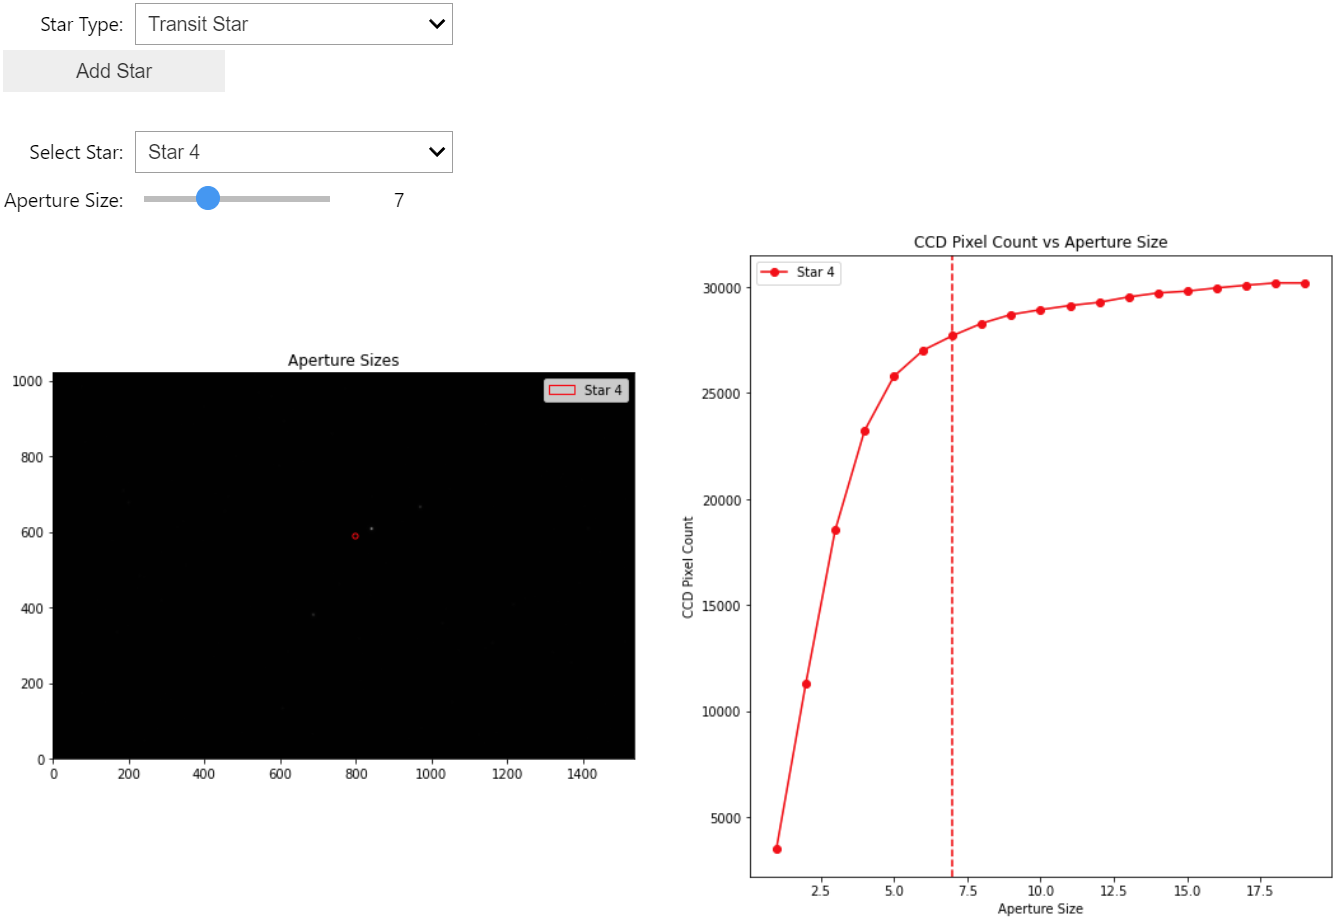

you can also identify which stars are your comparison, and which is your transit star. first get a finder chart from <a href="http://var2.astro.cz/ETD/predictions.php">Exoplanet Transit Database</a> to help you find which star is yours. its not necessarily the brightest or in the exact center of your image, so you need this to identify your star. 

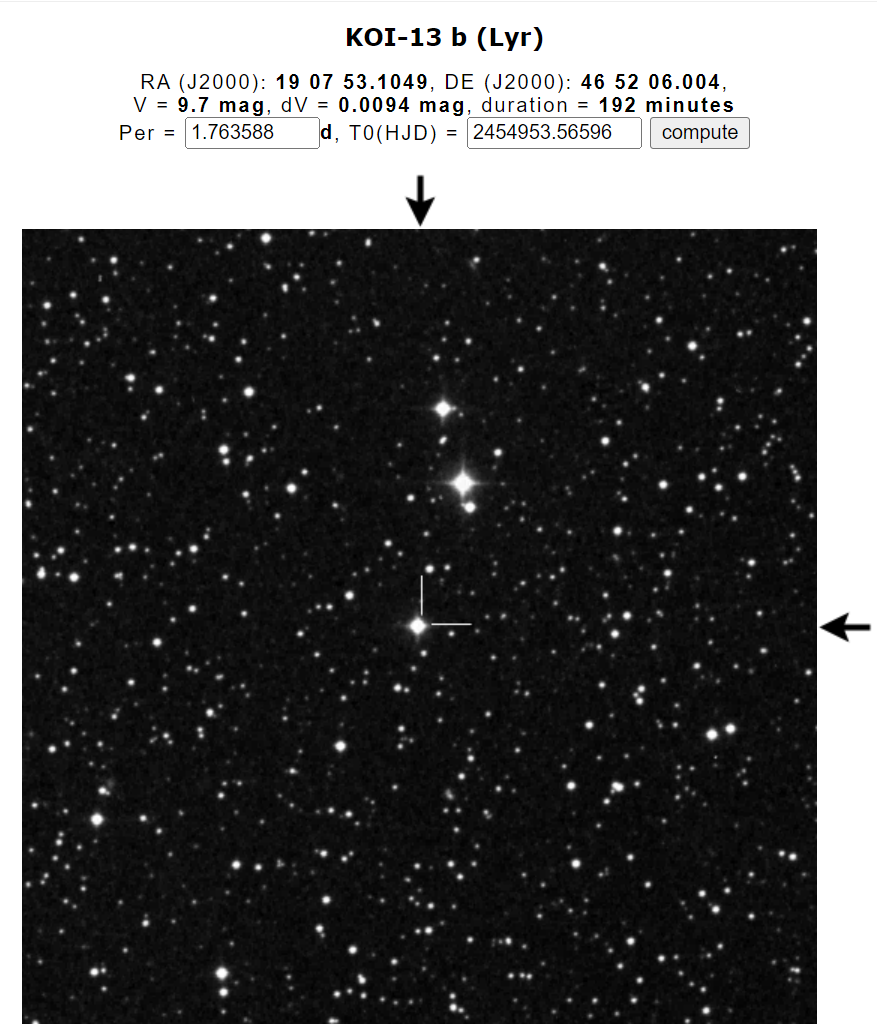
</p>

In [ ]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from photutils.detection import find_peaks
from photutils.aperture import CircularAperture, aperture_photometry
from ipywidgets import IntSlider, Dropdown, Button, VBox, Output, interactive
from astropy.stats import sigma_clipped_stats
from photutils.background import Background2D, MedianBackground
from astropy.modeling.models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter

class ApertureTest:
    def __init__(self):
        self.selected_stars = []
        self.out = Output()

    def perform_test(self, filepath, aperture_sizes):
        try:
            with fits.open(filepath) as hdul:
                frame_data = hdul[0].data
        except Exception as e:
            print(f"Error opening FITS file: {e}")
            return

        bkg = Background2D(frame_data, (50, 50), filter_size=(3, 3), bkg_estimator=MedianBackground())
        data_sub = frame_data - bkg.background
        mean, median, std = sigma_clipped_stats(data_sub, sigma=3.0)
        threshold = 20.0 * std
        tbl = find_peaks(data_sub, threshold, box_size=11)

        if tbl is not None and len(tbl) > 0:
            sorted_sources = tbl[np.argsort(tbl['peak_value'])[::-1]][:40]
            positions = np.array(list(zip(sorted_sources['x_peak'], sorted_sources['y_peak'])))
            brightness = sorted_sources['peak_value']

            valid_positions = []
            valid_brightness = []

            for i, pos in enumerate(positions):
                x, y = pos
                size = 5
                if x-size < 0 or x+size >= data_sub.shape[1] or y-size < 0 or y+size >= data_sub.shape[0]:
                    continue

                cutout = data_sub[y-size:y+size+1, x-size:x+size+1]
                y_grid, x_grid = np.mgrid[:cutout.shape[0], :cutout.shape[1]]
                initial_guess = Gaussian2D(amplitude=cutout.max(), x_mean=size, y_mean=size)
                fit_p = LevMarLSQFitter()

                try:
                    gauss_fit = fit_p(initial_guess, x_grid, y_grid, cutout)
                    fwhm_x = 2.355 * gauss_fit.x_stddev.value
                    fwhm_y = 2.355 * gauss_fit.y_stddev.value
                    fwhm = np.sqrt(fwhm_x * fwhm_y)

                    if fwhm >= 2:
                        valid_positions.append(pos)
                        valid_brightness.append(brightness[i])
                except Exception as e:
                    print(f"Gaussian fit failed for star at position {pos}: {e}")

            if len(valid_positions) == 0:
                print("No valid stars found with FWHM >= 3 pixels.")
                return

            self.positions = np.array(valid_positions)
            self.brightness = np.array(valid_brightness)
            self.aperture_sums = []
            self.frame_data = frame_data
            self.aperture_sizes = aperture_sizes
            for aperture_size in aperture_sizes:
                aperture = CircularAperture(self.positions, r=aperture_size)
                phot_table = aperture_photometry(data_sub, aperture)
                aperture_sum_values = np.maximum(phot_table['aperture_sum'], 0)
                self.aperture_sums.append(aperture_sum_values)

            self.create_widgets()

    def create_widgets(self):
        star_selector = Dropdown(options=[(f'Star {i+1}', i+1) for i in range(len(self.positions))], description='Select Star:')
        star_type_selector = Dropdown(options=[('Transit Star', 'Transit Star'), ('Comparison Star', 'Comparison Star')], description='Star Type:')
        slider = IntSlider(min=self.aperture_sizes.min(), max=self.aperture_sizes.max(), step=1, value=self.aperture_sizes[len(self.aperture_sizes) // 2], description='Aperture Size:')
        add_button = Button(description='Add Star')

        def plot_pixel_count_and_image(selected_star, aperture_size):
            selected_star_idx = selected_star - 1
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
            ax1.imshow(self.frame_data, cmap='gray', origin='lower')
            color = 'red'
            pos = self.positions[selected_star_idx]
            aperture = CircularAperture([pos], r=aperture_size)
            aperture.plot(ax1, color=color, label=f'Star {selected_star}')
            ax1.legend()
            ax1.set_title('Aperture Sizes')
            ax2.plot(self.aperture_sizes, [ap_sum[selected_star_idx] for ap_sum in self.aperture_sums], marker='o', color=color, label=f'Star {selected_star}')
            ax2.axvline(x=aperture_size, color=color, linestyle='--')
            ax2.set_xlabel('Aperture Size')
            ax2.set_ylabel('CCD Pixel Count')
            ax2.set_title('CCD Pixel Count vs Aperture Size')
            ax2.legend()
            plt.show()

        def add_star_to_list(selected_star, aperture_size, star_type):
            selected_star_idx = selected_star - 1
            pos = self.positions[selected_star_idx]
            self.selected_stars.append({'star': selected_star, 'position': pos, 'aperture_size': aperture_size, 'type': star_type})
            with self.out:
                print(f"Added {star_type} Star {selected_star} at position {pos} with aperture size {aperture_size}")
            plot_pixel_count_and_image(selected_star, aperture_size)

        def on_button_click(b):
            add_star_to_list(star_selector.value, slider.value, star_type_selector.value)

        add_button.on_click(on_button_click)

        display(VBox([star_type_selector, add_button, self.out]))
        
        interactive_plot = interactive(plot_pixel_count_and_image, selected_star=star_selector, aperture_size=slider)
        display(interactive_plot)

    def get_selected_stars(self):
        return self.selected_stars

# Perform the test on a single image file
aperture_test = ApertureTest()
aperture_sizes = np.arange(1, 20, 1)
aperture_test.perform_test("D:\\TransitResearch\\2024-05-19+20\\calibrated_images\\KOI-13_LIGHT_R_3s_BIN2_-10C_032_20240520_015233_755_PA338.fit", aperture_sizes)

# To access the selected stars list:
selected_stars = aperture_test.get_selected_stars()

# Example of accessing the pixel coordinates, aperture size, and star type
for star in selected_stars:
    print(f"Star: {star['star']}, Position: {star['position']}, Aperture Size: {star['aperture_size']}, Type: {star['type']}")


<h2 style="color: skyblue;" id="star-tracking">Section 5: Star Tracking</h2>
<p>
While the 1 meter pointing accuracy is great, you still need to track your stars from image to image. A change in position of a single pixel can change the brightness inside the aperture too much to extract the roughly 1% change from your transit. 

This involves taking the list of chosen stars from your aperture test and correcting their position from image to image. This is done by recentering the aperture onto the brightest pixel or point. 
</p>

In [ ]:
import os
from scipy.ndimage import center_of_mass
from astropy.io import fits

# Separate the stars into transit star and comparison stars
transit_star = [star for star in selected_stars if star['type'] == 'Transit Star'][0]
comparison_stars = [star for star in selected_stars if star['type'] == 'Comparison Star']

def calculate_centroid(image, position, box_size=15):
    y, x = position
    half_size = box_size // 2
    
    # Ensure sub-image does not go out of image bounds
    y_min = max(0, y - half_size)
    y_max = min(image.shape[0], y + half_size + 1)
    x_min = max(0, x - half_size)
    x_max = min(image.shape[1], x + half_size + 1)
    
    sub_image = image[y_min:y_max, x_min:x_max]
    
    # Calculate center of mass within the sub-image
    cy, cx = center_of_mass(sub_image)
    
    # Adjust centroid position to the main image's coordinate system
    return y_min + cy, x_min + cx

def recenter_stars(image_folder, keyword, initial_positions, box_size=15):
    recentered_positions = [initial_positions]
    
    for filename in sorted(os.listdir(image_folder)):
        if keyword in filename:
            file_path = os.path.join(image_folder, filename)
            with fits.open(file_path) as hdul:
                image = hdul[0].data

            current_positions = []
            for pos in initial_positions:
                centroid = calculate_centroid(image, pos, box_size)
                current_positions.append(centroid)
            recentered_positions.append(current_positions)
    
    return recentered_positions

# Example usage:
folder = "D:\\TransitResearch\\2024-05-19+20\\calibrated_images"
keyword = "KOI"

# Get initial positions of the transit star and comparison stars
initial_positions = [transit_star['position']] + [star['position'] for star in comparison_stars]

# Box size can be customized based on the aperture size used
aperture_size = 15
recentered_positions = recenter_stars(folder, keyword, initial_positions, box_size=aperture_size)

# Print recentered positions for verification
for idx, positions in enumerate(recentered_positions):
    print(f"Image {idx+1}:")
    for star_idx, pos in enumerate(positions):
        star_type = "Transit Star" if star_idx == 0 else f"Comparison Star {star_idx}"
        print(f"  {star_type}: Position {pos}")

# Proceed with differential photometry using the recentered_positions


<h2 style="color: skyblue;" id="differential-photometry">Section 6: Differential Photometry</h2>
<p>
</p>

In [ ]:
import numpy as np
import re
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from photutils.aperture import CircularAperture, aperture_photometry
from datetime import datetime

# Function for aperture photometry
def perform_photometry(image, positions, aperture_sizes):
    fluxes = []
    for pos, aperture_size in zip(positions, aperture_sizes):
        apertures = CircularAperture([pos], r=aperture_size)
        phot_table = aperture_photometry(image, apertures)
        fluxes.append(phot_table['aperture_sum'][0])
    return fluxes

# Extract the datetime from the filename
def extract_datetime_from_filename(filename):
    pattern = r'_(\d{8}_\d{6})_'
    match = re.search(pattern, filename)
    if match:
        datetime_str = match.group(1)
        datetime_obj = datetime.strptime(datetime_str, '%Y%m%d_%H%M%S')
        return datetime_obj
    else:
        raise ValueError(f"Filename {filename} does not contain a valid datetime format")

# Function for differential photometry using recentered positions
def differential_photometry(image_folder, keyword, selected_stars, recentered_positions):
    transit_flux = []
    comparison_fluxes = []
    times = []

    files = [f for f in os.listdir(image_folder) if keyword in f]
    files.sort(key=extract_datetime_from_filename)

    print("Sorted files by datetime:")
    for f in files:
        print(f"{f}: {extract_datetime_from_filename(f)}")

    for idx, filename in enumerate(files):
        file_path = os.path.join(image_folder, filename)
        with fits.open(file_path) as hdul:
            image = hdul[0].data

        current_positions = recentered_positions[idx]
        positions = [current_positions[i] for i in range(len(selected_stars))]
        aperture_sizes = [star['aperture_size'] for star in selected_stars]
        types = [star['type'] for star in selected_stars]

        fluxes = perform_photometry(image, positions, aperture_sizes)

        transit_flux.append(fluxes[types.index('Transit Star')])
        comparison_fluxes.append([flux for flux, star_type in zip(fluxes, types) if star_type == 'Comparison Star'])

        extracted_time = extract_datetime_from_filename(filename)
        print(f"Filename: {filename}, Extracted Time: {extracted_time}")
        times.append(extracted_time)

    # Flatten the comparison fluxes for plotting
    comparison_fluxes = np.array(comparison_fluxes).T

    # Plot the brightness of the transit star
    plt.figure(figsize=(10, 6))
    plt.plot(times, transit_flux, marker='o', linestyle='-', color='r', label='Transit Star')
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.title('Brightness of Transit Star Over Time')
    plt.grid(True)

    # Format x-axis to display datetime values
    date_format = DateFormatter("%Y-%m-%d %H:%M:%S")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels

    plt.tight_layout()
    plt.legend()
    plt.show()

    # Plot the brightness of each comparison star
    plt.figure(figsize=(10, 6))
    for i, comp_flux in enumerate(comparison_fluxes):
        plt.plot(times, comp_flux, marker='o', linestyle='-', label=f'Comparison Star {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.title('Brightness of Comparison Stars Over Time')
    plt.grid(True)

    # Format x-axis to display datetime values
    date_format = DateFormatter("%Y-%m-%d %H:%M:%S")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels

    plt.tight_layout()
    plt.legend()
    plt.show()

    # Calculate the differential light curve
    normalized_flux = np.array(transit_flux) / np.mean(comparison_fluxes, axis=0)

    # Plot the light curve
    plt.figure(figsize=(10, 6))
    plt.plot(times, normalized_flux, marker='o', linestyle='-', color='b')
    plt.xlabel('Time')
    plt.ylabel('Normalized Flux')
    plt.title('Differential Light Curve')
    plt.grid(True)

    # Format x-axis to display datetime values
    date_format = DateFormatter("%Y-%m-%d %H:%M:%S")
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gcf().autofmt_xdate()  # Rotate and format the x-axis labels

    plt.tight_layout()
    plt.show()

# Example usage
folder = "D:\\TransitResearch\\2024-05-19+20\\calibrated_images"
keyword = "KOI"

# Use the recentered_positions from the recenter_stars function
# recentered_positions = recenter_stars(folder, keyword, initial_positions, box_size=aperture_size)

differential_photometry(folder, keyword, selected_stars, recentered_positions)




<h2 style="color: skyblue;" id="plotting-transit-brightness">Section 7: Plotting Transit</h2>
<p>
</p>

<h2 style="color: skyblue;" id="estimating-exoplanet-information">Section 8: Estimating Exoplanet Information</h2>
<p>
</p>